In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import *
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import *
from matplotlib.pyplot import figure
from sklearn.metrics import f1_score

In [5]:
tf_config = K.tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
session = K.tf.Session(config=tf_config)
K.set_session(session)

In [6]:
import pandas as pd
# df = pd.read_csv ('/data/Data/yntn/data_labeled_10M.csv')
df = pd.read_csv ('/data/Data/yntn/train.csv')

In [5]:
# label_tag = (list(set (df.label)))
# label_tag.sort()
# cutdata = []
# for i in range (len(label_tag)):
#     df_go = df[df.label == label_tag[i]].head(350000)
#     cutdata.append(df_go)

In [6]:
# df = pd.concat(cutdata, axis = 0)

Text(0.5, 0, 'Label')

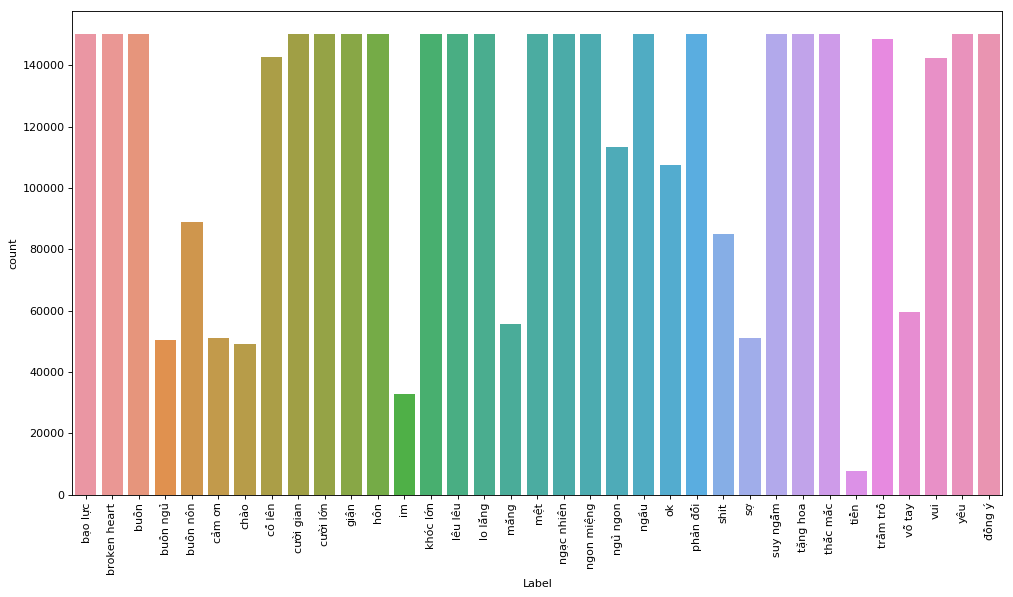

In [7]:
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
sns.countplot(df.target)
plt.xlabel('Label')

In [8]:
X = df.status
Y = df.target
le = LabelEncoder()
Y = le.fit_transform(Y)

In [9]:
onehot_Y = []

for i in range(len(Y)):
    tmp = []
    tmp = [ 0 for i in range(0, 35)] # set all 0
    tmp[Y[i]] = 1 
    onehot_Y.append(tmp)

In [10]:
Y = np.array(onehot_Y)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=11)

# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=11)

In [12]:
max_len = 30
max_words = 88860
tok = Tokenizer(num_words = max_words)
X_train = [str(s) for s in X_train]
tok.fit_on_texts(X_train)

max_words = len(tok.index_word)+1

sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [13]:
pickle.dump(tok, open('tokenize.pkl','wb'))

In [14]:
word_dict = pickle.load (open("/data/Data/yntn/word_embedding_vec.pkl",'rb'))

In [15]:
w = np.random.normal(0, 1, (max_words, 300))

In [16]:
for i in range (1, max_words):
    if (tok.index_word[i] in word_dict):
        w[i] = word_dict[tok.index_word[i]]

In [17]:
def RNN():
    inputs = Input(name = 'inputs', shape = [max_len])
    layer = Embedding(max_words, 300, input_length = max_len, weights = [w])(inputs)
    layer = CuDNNLSTM(128, return_sequences= True )(layer)
    layer = CuDNNLSTM(128, return_sequences= True )(layer)
    layer = GlobalMaxPooling1D()(layer)
    layer = Dense(256,name = 'FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(35,name = 'out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs = inputs,outputs = layer)
    return model

In [18]:
model  = RNN()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 300)           35031900  
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 30, 128)           220160    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 30, 128)           132096    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
FC1 (Dense)                  (None, 256)               33024     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
__________

In [26]:
# Compatible with tensorflow backend
import tensorflow as tf
# def focal_loss(gamma=10, alpha=.25):
def focal_loss(gamma=10, alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [19]:
model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(),metrics = ['accuracy'])

## focal loss
# model.compile(loss=[focal_loss(alpha=.25, gamma=10)], metrics=["accuracy"], optimizer='adam')

In [20]:
weight_file = "model_LSTM_w13_xTrainCsv.hdf5"
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1),
    ModelCheckpoint(weight_file, monitor = 'val_loss', verbose = 1, save_best_only = True)
]

In [21]:
history = model.fit(sequences_matrix,Y_train,batch_size = 2048, epochs = 10,
          validation_split = 0.2, callbacks = callbacks)

Train on 2678984 samples, validate on 669747 samples
Epoch 1/10
2678984/2678984 [==============================] - 65s 24us/step - loss: 2.9370 - acc: 0.1944 - val_loss: 2.8256 - val_acc: 0.2192

Epoch 00001: val_loss improved from inf to 2.82558, saving model to model_LSTM_w13_xTrainCsv.hdf5
Epoch 2/10
2678984/2678984 [==============================] - 62s 23us/step - loss: 2.8129 - acc: 0.2256 - val_loss: 2.7888 - val_acc: 0.2274

Epoch 00002: val_loss improved from 2.82558 to 2.78885, saving model to model_LSTM_w13_xTrainCsv.hdf5
Epoch 3/10
2678984/2678984 [==============================] - 62s 23us/step - loss: 2.7752 - acc: 0.2342 - val_loss: 2.7726 - val_acc: 0.2323

Epoch 00003: val_loss improved from 2.78885 to 2.77259, saving model to model_LSTM_w13_xTrainCsv.hdf5
Epoch 4/10
2678984/2678984 [==============================] - 63s 23us/step - loss: 2.7484 - acc: 0.2402 - val_loss: 2.7575 - val_acc: 0.2356

Epoch 00004: val_loss improved from 2.77259 to 2.75747, saving model to m

In [22]:
X_test = [str(s) for s in X_test]
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)

837183/837183 [==============================] - 98s 117us/step


In [23]:
preds = model.predict(test_sequences_matrix, batch_size=2048)

In [24]:
f1_score(Y_test.argmax(1), preds.argmax(1), average='macro')

0.2103563037727155

In [25]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 2.772
  Accuracy: 0.237
